# Programa de Cosecha • Metaheurísticas (GA, SA, TS)

Este notebook ejecuta el flujo completo: generación de datos, evaluación y las tres metaheurísticas.
El costo que se grafica es el **costo penalizado a minimizar**, por lo que **debe disminuir**.

In [38]:
import sys
from pathlib import Path
# Asegura que el directorio del proyecto (padre de 'notebooks/') esté en sys.path
PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [39]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from core.model import generate_problem, evaluate, greedy_baseline
from core.ga import run_ga
from core.sa import run_sa
from core.tabu import run_tabu
from core.utils import plot_convergence

ARTIFACTS = Path('../artifacts')
ARTIFACTS.mkdir(parents=True, exist_ok=True)

## 1) Parámetros del problema

In [40]:
seed = 42
N = 30
workers = 10
K = 3
C = 1800

problem = generate_problem(N=N, workers=workers, K=K, C=C, seed=seed)
df = pd.DataFrame({
    'parcela': np.arange(problem.N, dtype=int),
    'Vi_kg': problem.V.astype(int),
    'Pi_horas': problem.P.astype(float),
    'ratio_Vi_Pi': (problem.V / np.maximum(problem.P, 1e-9))
})
df.head()

,parcela,Vi_kg,Pi_horas,ratio_Vi_Pi
0,0,198,3.05,64.918033
1,1,952,5.99,158.931553
2,2,820,1.57,522.292994
3,3,583,8.45,68.994083
4,4,576,6.68,86.227545


## 2) Baseline greedy y evaluación

In [41]:
xg = greedy_baseline(problem)
ev_g = evaluate(problem, xg)
ev_g

{'Z': 5315,
 'hours_used': 16.9,
 'kg_used': 5315,
 'feasible_hours': True,
 'feasible_capacity': True,
 'feasible_all': True}

## 3) Algoritmo Genético (GA)

{'Z': 5398,
 'hours_used': 50.54,
 'kg_used': 5398,
 'feasible_hours': True,
 'feasible_capacity': True,
 'feasible_all': True}

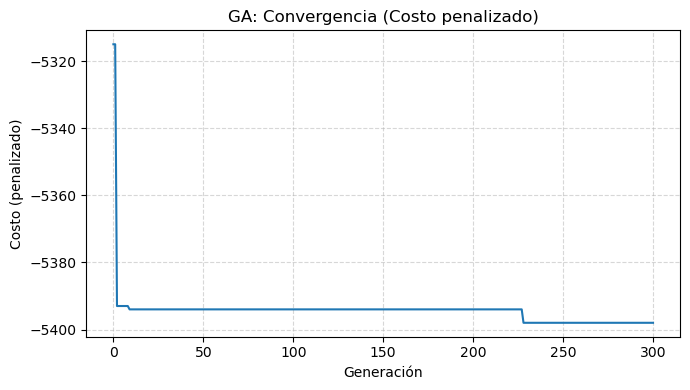

In [42]:
ga_params = dict(pop=80, gens=300, pc=0.8, pm=0.02, elite=1, tournament_k=3)
ga_res = run_ga(problem, ga_params, seed=seed)
fig, _ = plot_convergence(ga_res.history_best_cost, 'GA: Convergencia (Costo penalizado)', 'Generación')
fig.savefig(ARTIFACTS / 'ga_convergence.png', dpi=150)
evaluate(problem, ga_res.best_X)

## 4) Recocido Simulado (SA)

{'Z': 5349,
 'hours_used': 55.849999999999994,
 'kg_used': 5349,
 'feasible_hours': True,
 'feasible_capacity': True,
 'feasible_all': True}

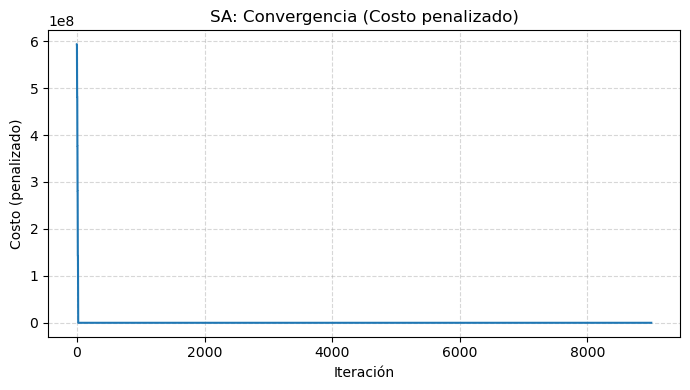

In [43]:
sa_params = dict(T0=1.0, Tend=1e-3, iters=N*300, alpha=0.99)
sa_res = run_sa(problem, sa_params, seed=seed)
fig, _ = plot_convergence(sa_res.history_best_cost, 'SA: Convergencia (Costo penalizado)', 'Iteración')
fig.savefig(ARTIFACTS / 'sa_convergence.png', dpi=150)
evaluate(problem, sa_res.best_X)

## 5) Búsqueda Tabú (TS)

{'Z': 5398,
 'hours_used': 55.46,
 'kg_used': 5398,
 'feasible_hours': True,
 'feasible_capacity': True,
 'feasible_all': True}

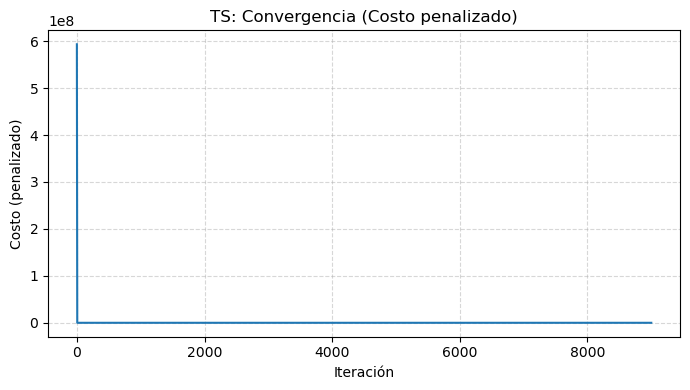

In [44]:
ts_params = dict(iters=N*300, tabu_size=int(np.ceil(0.1*N)), consider_all=True)
ts_res = run_tabu(problem, ts_params, seed=seed)
fig, _ = plot_convergence(ts_res.history_best_cost, 'TS: Convergencia (Costo penalizado)', 'Iteración')
fig.savefig(ARTIFACTS / 'ts_convergence.png', dpi=150)
evaluate(problem, ts_res.best_X)

## 6) Comparativa

In [45]:
rows = []
for name, res, x in [
    ('GA', ga_res, ga_res.best_X),
    ('SA', sa_res, sa_res.best_X),
    ('TS', ts_res, ts_res.best_X),
]:
    ev = evaluate(problem, x)
    rows.append({
        'algoritmo': name,
        'Z': ev['Z'],
        'hours_used': ev['hours_used'],
        'kg_used': ev['kg_used'],
        'feasible': ev['feasible_all'],
        'best_cost': (res.history_best_cost[-1] if hasattr(res, 'history_best_cost') else None),
    })
comp_df = pd.DataFrame(rows)
comp_df

,algoritmo,Z,hours_used,kg_used,feasible,best_cost
0,GA,5398,50.54,5398,True,-5398.0
1,SA,5349,55.85,5349,True,-5349.0
2,TS,5398,55.46,5398,True,-5398.0


## 7) Exportar resultados

In [46]:
best_name, best_res = max([('GA', ga_res), ('SA', sa_res), ('TS', ts_res)], key=lambda t: evaluate(problem, t[1].best_X)['Z'])
best_x = best_res.best_X
df_out = df.copy()
df_out['X'] = best_x
df_out.to_csv(ARTIFACTS / 'best_solution.csv', index=False)
(best_name, evaluate(problem, best_x))

('GA',
 {'Z': 5398,
  'hours_used': 50.54,
  'kg_used': 5398,
  'feasible_hours': True,
  'feasible_capacity': True,
  'feasible_all': True})

## 8) Conclusiones breves

- Se compararon GA, SA y TS sobre un dataset reproducible.
- Se observó descenso del costo penalizado en las tres técnicas, con variaciones en velocidad de convergencia.
- El mejor algoritmo para este dataset es el que obtuvo mayor **Z** factible (ver tabla comparativa); puede variar con `seed`.